<a href="https://colab.research.google.com/github/samyak1512/MLprojects-random/blob/main/Rossman_Store_Sales_Data_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [290]:
!pip install pmdarima

In [291]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [292]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import logging
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.stattools import kpss,adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
# from lightgbm import LGBMRegressor
# from prophet import Prophet
logging.getLogger("cmdstanpy").disabled = True
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from itertools import product

In [293]:
store_details = pd.read_csv("/content/drive/MyDrive/dataset machine learning/rossmann-store-sales/store.csv")

In [294]:
store_details

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [295]:
store_details= pd.get_dummies(store_details, columns=["StoreType"])
store_details = pd.get_dummies(store_details, columns=["Assortment"])
store_details = pd.get_dummies(store_details, columns=["PromoInterval"])
# df = pd.get_dummies(df, columns=["StoreType"])


In [296]:
# prompt: Using dataframe train_data: prepare a correlation matrix in plotly

import pandas as pd
import plotly.express as px

# Create a correlation matrix
correlation_matrix = store_details.corr()

# Generate a heatmap using plotly express
fig = px.imshow(correlation_matrix,
              x=correlation_matrix.columns,
              y=correlation_matrix.index,
              color_continuous_scale='Viridis',
              text_auto=True,
                aspect="auto")

# Update the layout
fig.update_layout(
    title='Correlation Matrix of Train Data',
    xaxis_title='Features',
    yaxis_title='Features'
)

# Show the plot
fig.show()

In [297]:
df = pd.read_csv("/content/drive/MyDrive/dataset machine learning/rossmann-store-sales/train.csv", index_col = "Date", low_memory=False, parse_dates=['Date'])

In [298]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


In [299]:
# prompt: join two tables by a cloumn which is not the index

import pandas as pd
merged_df = df.reset_index().merge(store_details, on='Store').set_index('Date')


In [300]:
merged_df

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,...,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
2015-07-30,1,4,5020,546,1,1,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
2015-07-29,1,3,4782,523,1,1,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
2015-07-28,1,2,5011,560,1,1,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
2015-07-27,1,1,6102,612,1,1,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-05,1115,6,4771,339,1,0,0,1,5350.0,NaN,...,False,False,False,True,False,False,True,False,False,True
2013-01-04,1115,5,4540,326,1,0,0,1,5350.0,NaN,...,False,False,False,True,False,False,True,False,False,True
2013-01-03,1115,4,4297,300,1,0,0,1,5350.0,NaN,...,False,False,False,True,False,False,True,False,False,True


In [301]:
df = merged_df

In [302]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 24 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   Store                           1017209 non-null  int64  
 1   DayOfWeek                       1017209 non-null  int64  
 2   Sales                           1017209 non-null  int64  
 3   Customers                       1017209 non-null  int64  
 4   Open                            1017209 non-null  int64  
 5   Promo                           1017209 non-null  int64  
 6   StateHoliday                    1017209 non-null  object 
 7   SchoolHoliday                   1017209 non-null  int64  
 8   CompetitionDistance             1014567 non-null  float64
 9   CompetitionOpenSinceMonth       693861 non-null   float64
 10  CompetitionOpenSinceYear        693861 non-null   float64
 11  Promo2                          1017209 non-null

In [303]:
store_number_er = 1

In [304]:
df = df[df["Store"] == store_number_er]

In [305]:
df = df.asfreq('D')

In [306]:
df.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-07-22', '2015-07-23', '2015-07-24', '2015-07-25',
               '2015-07-26', '2015-07-27', '2015-07-28', '2015-07-29',
               '2015-07-30', '2015-07-31'],
              dtype='datetime64[ns]', name='Date', length=942, freq='D')

In [307]:
df

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,...,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,2,0,0,0,0,a,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
2013-01-02,1,3,5530,668,1,0,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
2013-01-03,1,4,4327,578,1,0,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
2013-01-04,1,5,4486,619,1,0,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
2013-01-05,1,6,4997,635,1,0,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,1,1,6102,612,1,1,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
2015-07-28,1,2,5011,560,1,1,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
2015-07-29,1,3,4782,523,1,1,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False


In [308]:
df.sort_values(by="Date", inplace=True)
df = df.drop(df[df['Open'] == 0].index)

In [309]:
df

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,...,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,1,3,5530,668,1,0,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
2013-01-03,1,4,4327,578,1,0,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
2013-01-04,1,5,4486,619,1,0,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
2013-01-05,1,6,4997,635,1,0,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
2013-01-07,1,1,7176,785,1,1,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,1,1,6102,612,1,1,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
2015-07-28,1,2,5011,560,1,1,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
2015-07-29,1,3,4782,523,1,1,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False


In [310]:
train_size = int(len(df) * 0.8)
train_data = df[:train_size].copy(deep=True)
test_data = df[train_size:].copy(deep=True)

In [311]:
import plotly.express as px

In [312]:
# prompt: create line chart using plotly

fig = px.line(train_data, y="Sales", title="Daily Sales Trend for Store 1")
fig.show()


In [313]:
fig = px.line(train_data[:30], y="Sales", title="Monthly Sales Trend for Store 1")
fig.show()

In [314]:
fig = px.line(train_data[:365], y="Sales", title="Monthly Sales Trend for Store 1")
fig.show()

In [315]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day

# Convert the columns to integers
df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(int)
df['day'] = df['day'].astype(int)

In [316]:
# prompt: create line chart using plotly of store_1 and sales but only for 1 week

store_1_week = train_data.iloc[:7, :]
fig = px.line(store_1_week,y="Sales", title="Daily Sales Trend for Store 1 (First Week)")
fig.show()


In [317]:
# prompt: create line chart using plotly of store_1 and sales but only for 2nd week

store_1_week2 = train_data.iloc[7:14, :]
fig = px.line(store_1_week2, y="Sales", title="Daily Sales Trend for Store 1 (Second Week)")
fig.show()


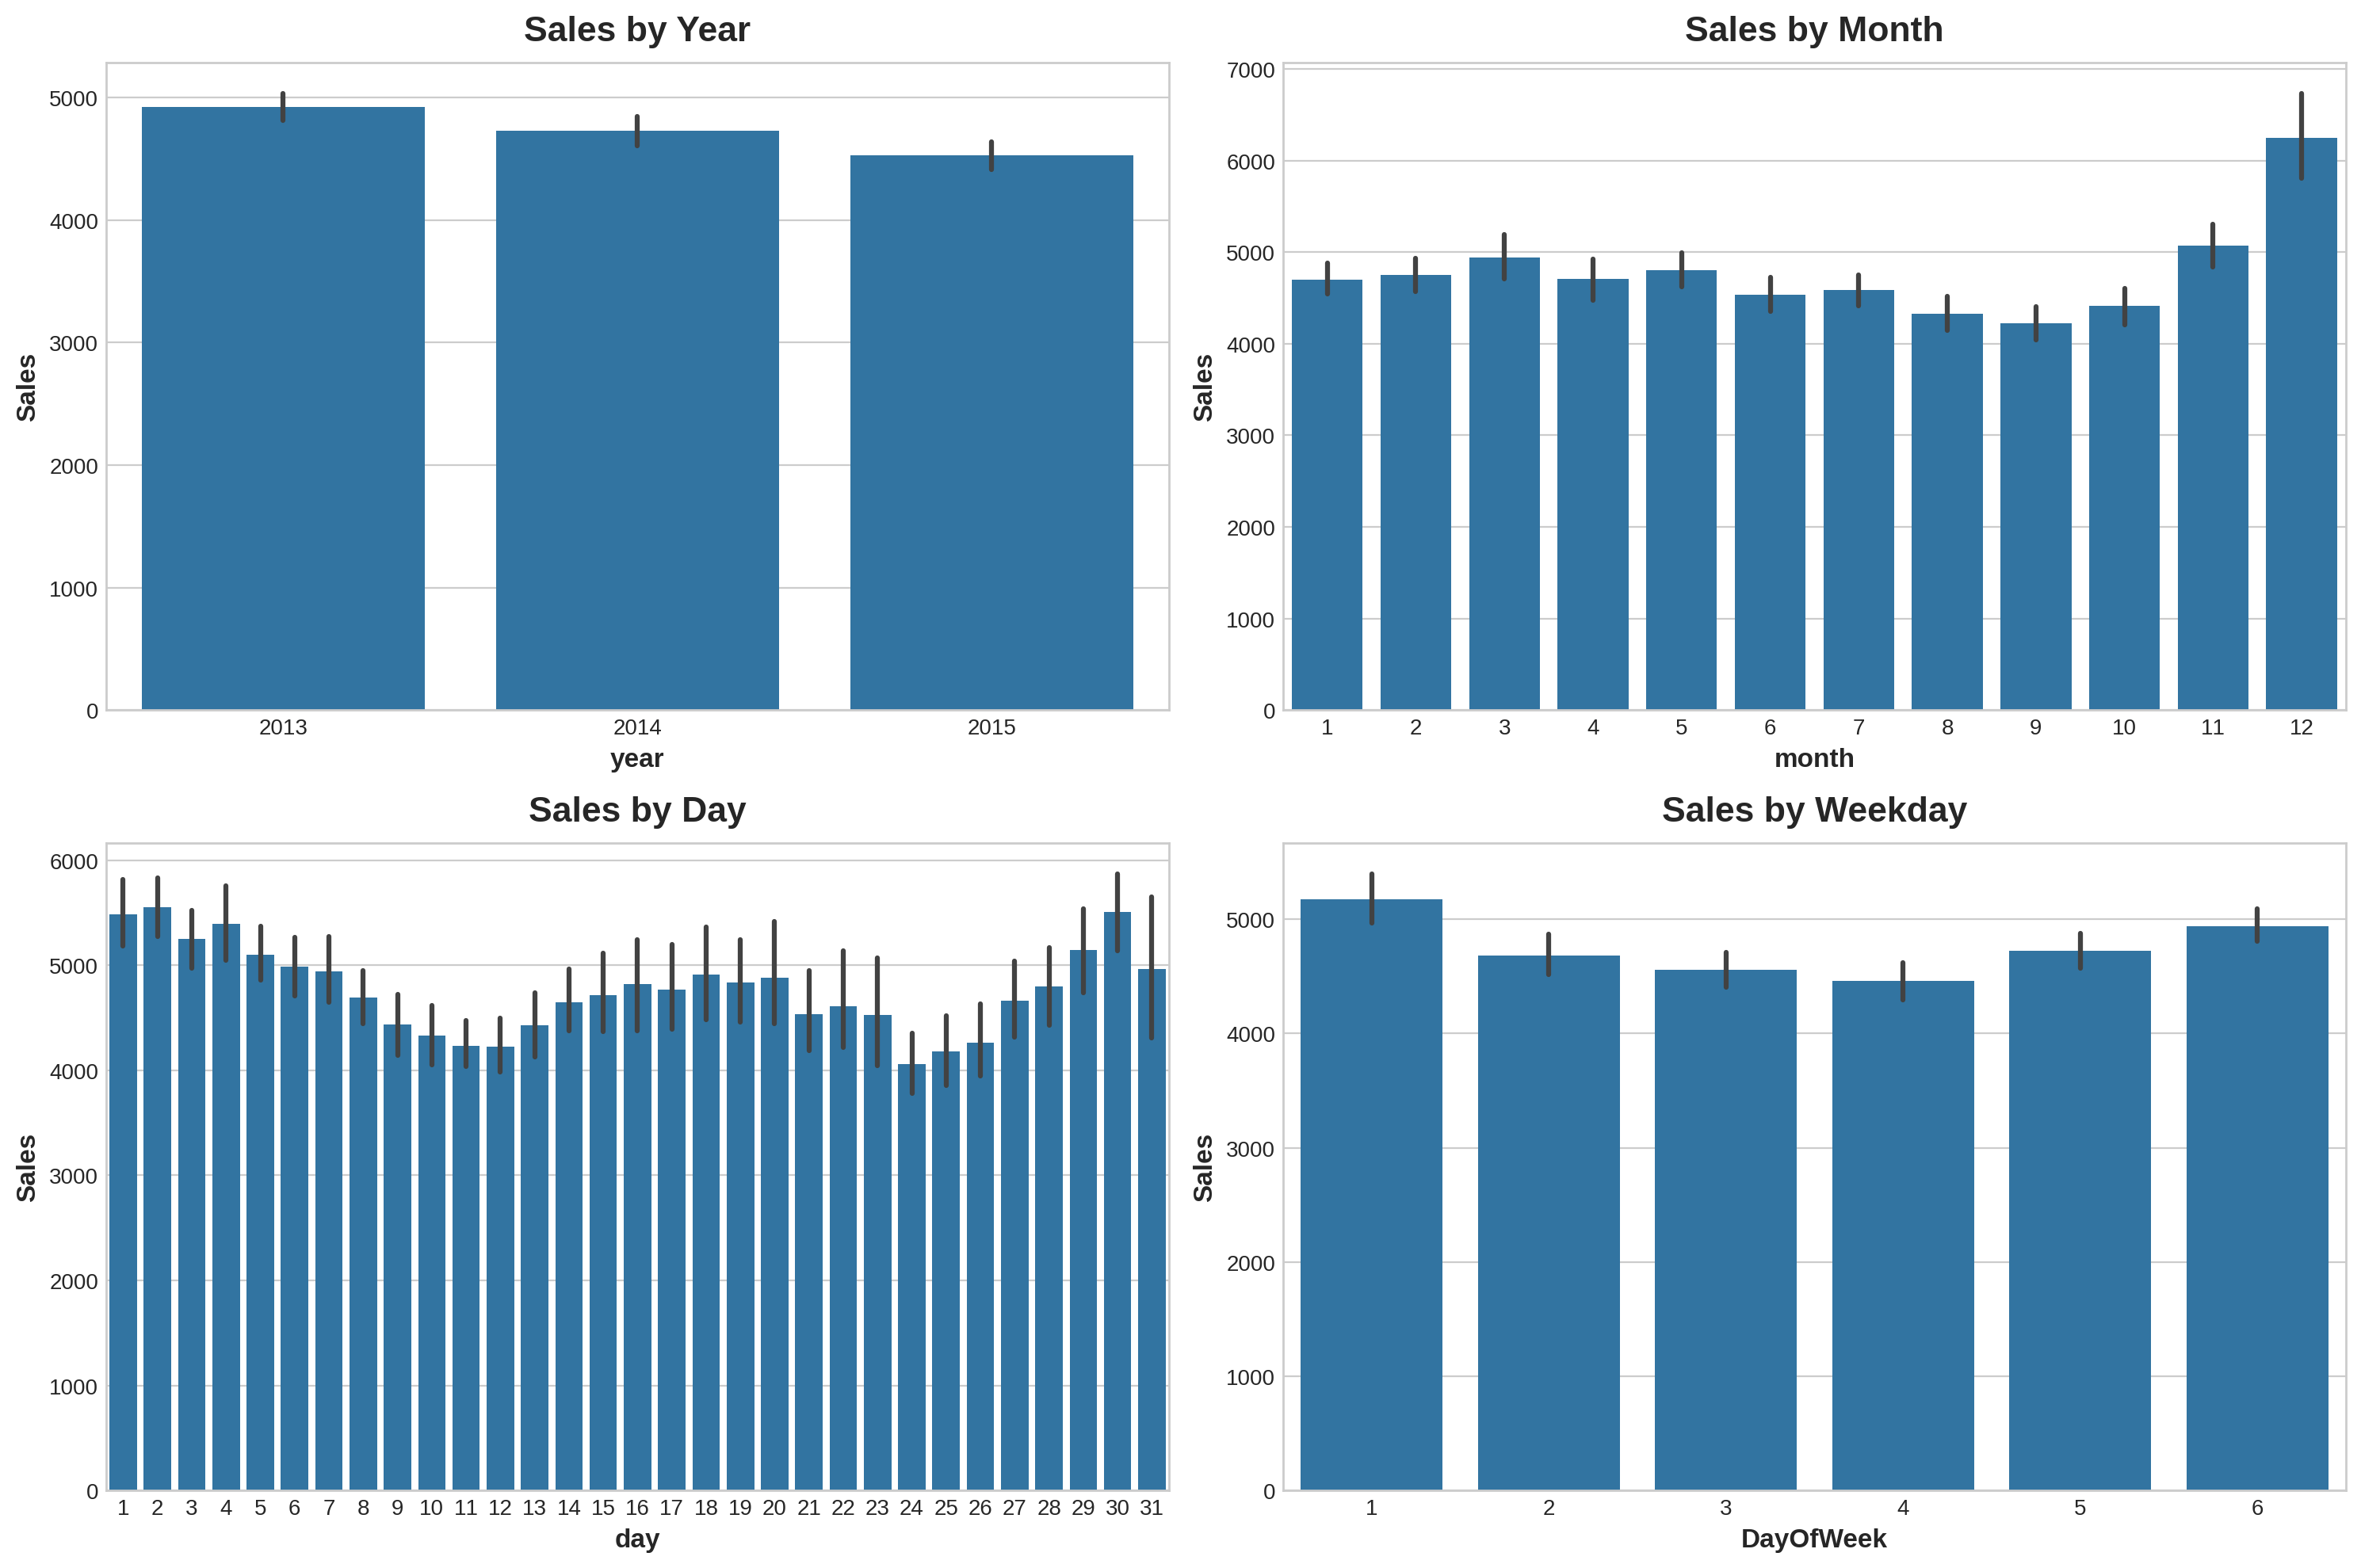

In [318]:
# Create a grid of bar charts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.barplot(x='year',y="Sales", data=df, ax=axes[0, 0])
sns.barplot(x='month',y="Sales", data=df, ax=axes[0, 1])
sns.barplot(x='day',y="Sales", data=df, ax=axes[1, 0])
sns.barplot(x='DayOfWeek',y="Sales", data=df, ax=axes[1, 1])

# Set the titles for each chart
axes[0, 0].set_title('Sales by Year')
axes[0, 1].set_title('Sales by Month')
axes[1, 0].set_title('Sales by Day')
axes[1, 1].set_title('Sales by Weekday')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the grid of bar charts
plt.show()

In [319]:
def monthly_quarter_line_plot(df,col_x,col_y,hue_col,title="Monthly"):
    plt.figure(figsize=(10,8))
    sns.lineplot(data=train_data,
                 x=col_x,
                 y=col_y,
                 hue=hue_col,
                 palette="tab10")

    # add title
    plt.title(title+' Seasonal plot')


In [320]:
# prompt: apply one hot encoding on state holiday on dataset store_1

import pandas as pd
df = pd.get_dummies(df, columns=["StateHoliday"])
df = pd.get_dummies(df, columns=["DayOfWeek"])
# df = pd.get_dummies(df, columns=["Assortment"])
# df = pd.get_dummies(df, columns=["StoreType"])



In [321]:
df

,Store,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,...,year,month,day,StateHoliday_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,1,5530,668,1,0,1,1270.0,9.0,2008.0,0,...,2013,1,2,True,False,False,True,False,False,False
2013-01-03,1,4327,578,1,0,1,1270.0,9.0,2008.0,0,...,2013,1,3,True,False,False,False,True,False,False
2013-01-04,1,4486,619,1,0,1,1270.0,9.0,2008.0,0,...,2013,1,4,True,False,False,False,False,True,False
2013-01-05,1,4997,635,1,0,1,1270.0,9.0,2008.0,0,...,2013,1,5,True,False,False,False,False,False,True
2013-01-07,1,7176,785,1,1,1,1270.0,9.0,2008.0,0,...,2013,1,7,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,1,6102,612,1,1,1,1270.0,9.0,2008.0,0,...,2015,7,27,True,True,False,False,False,False,False
2015-07-28,1,5011,560,1,1,1,1270.0,9.0,2008.0,0,...,2015,7,28,True,False,True,False,False,False,False
2015-07-29,1,4782,523,1,1,1,1270.0,9.0,2008.0,0,...,2015,7,29,True,False,False,True,False,False,False


In [322]:
df# prompt: drop store column from df

df = df.drop(columns=["Store"])
df= df.drop(columns = ["SchoolHoliday"])
# df = df.drop(columns = ["PromoInterval"])


In [323]:
df

,Sales,Customers,Open,Promo,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,...,year,month,day,StateHoliday_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,5530,668,1,0,1270.0,9.0,2008.0,0,NaN,NaN,...,2013,1,2,True,False,False,True,False,False,False
2013-01-03,4327,578,1,0,1270.0,9.0,2008.0,0,NaN,NaN,...,2013,1,3,True,False,False,False,True,False,False
2013-01-04,4486,619,1,0,1270.0,9.0,2008.0,0,NaN,NaN,...,2013,1,4,True,False,False,False,False,True,False
2013-01-05,4997,635,1,0,1270.0,9.0,2008.0,0,NaN,NaN,...,2013,1,5,True,False,False,False,False,False,True
2013-01-07,7176,785,1,1,1270.0,9.0,2008.0,0,NaN,NaN,...,2013,1,7,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,6102,612,1,1,1270.0,9.0,2008.0,0,NaN,NaN,...,2015,7,27,True,True,False,False,False,False,False
2015-07-28,5011,560,1,1,1270.0,9.0,2008.0,0,NaN,NaN,...,2015,7,28,True,False,True,False,False,False,False
2015-07-29,4782,523,1,1,1270.0,9.0,2008.0,0,NaN,NaN,...,2015,7,29,True,False,False,True,False,False,False


In [324]:
# prompt: Using dataframe train_data: prepare a correlation matrix in plotly

import pandas as pd
import plotly.express as px

# Create a correlation matrix
correlation_matrix = df.corr()

# Generate a heatmap using plotly express
fig = px.imshow(correlation_matrix,
              x=correlation_matrix.columns,
              y=correlation_matrix.index,
              color_continuous_scale='Viridis',
              text_auto=True,
                aspect="auto")

# Update the layout
fig.update_layout(
    title='Correlation Matrix of Train Data',
    xaxis_title='Features',
    yaxis_title='Features'
)

# Show the plot
fig.show()

In [325]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

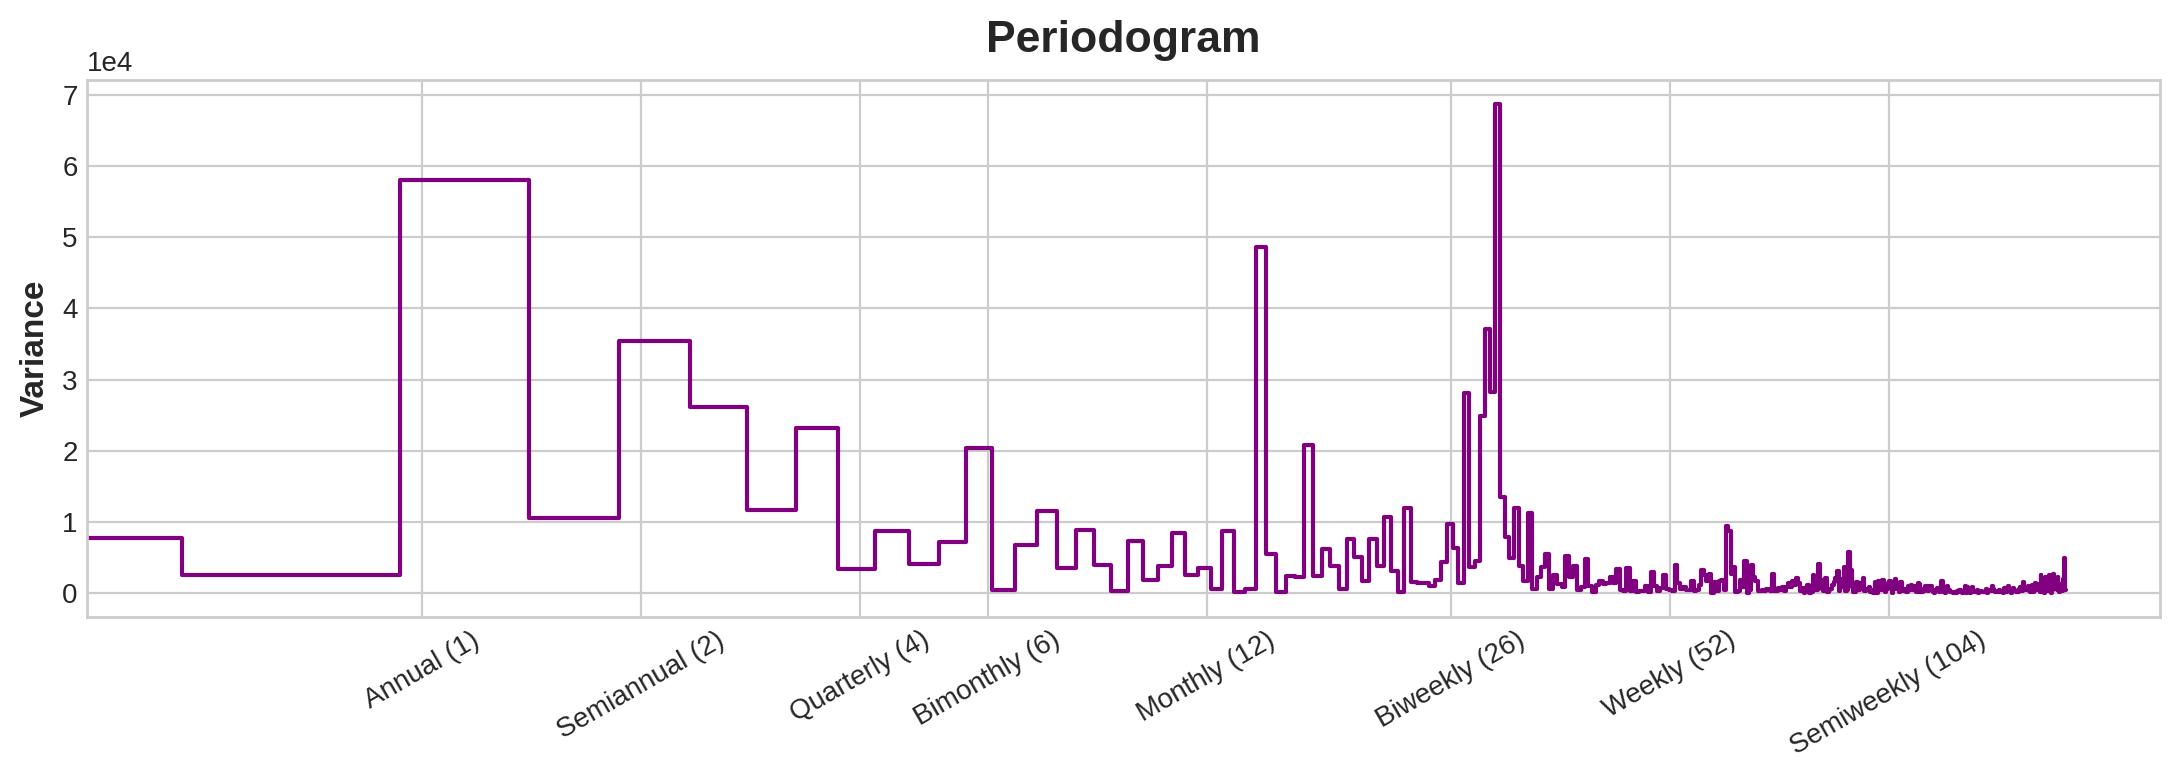

In [326]:
plot_periodogram(df.Sales);

In [327]:
df

,Sales,Customers,Open,Promo,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,...,year,month,day,StateHoliday_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,5530,668,1,0,1270.0,9.0,2008.0,0,NaN,NaN,...,2013,1,2,True,False,False,True,False,False,False
2013-01-03,4327,578,1,0,1270.0,9.0,2008.0,0,NaN,NaN,...,2013,1,3,True,False,False,False,True,False,False
2013-01-04,4486,619,1,0,1270.0,9.0,2008.0,0,NaN,NaN,...,2013,1,4,True,False,False,False,False,True,False
2013-01-05,4997,635,1,0,1270.0,9.0,2008.0,0,NaN,NaN,...,2013,1,5,True,False,False,False,False,False,True
2013-01-07,7176,785,1,1,1270.0,9.0,2008.0,0,NaN,NaN,...,2013,1,7,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,6102,612,1,1,1270.0,9.0,2008.0,0,NaN,NaN,...,2015,7,27,True,True,False,False,False,False,False
2015-07-28,5011,560,1,1,1270.0,9.0,2008.0,0,NaN,NaN,...,2015,7,28,True,False,True,False,False,False,False
2015-07-29,4782,523,1,1,1270.0,9.0,2008.0,0,NaN,NaN,...,2015,7,29,True,False,False,True,False,False,False


In [328]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=36)  # 10 sin/cos pairs for "A"nnual seasonality

# dp = DeterministicProcess(
#     index=df.index,
#     constant=True,               # dummy feature for bias (y-intercept)
#     order=1,                     # trend (order 1 means linear)
#     seasonal=True,               # weekly seasonality (indicators)
# #     additional_terms=[fourier],  # annual seasonality (fourier)
#     drop=True,                   # drop terms to avoid collinearity
# )
dp = DeterministicProcess(
    index=df.index,
    constant=True,
    order=1,  # Linear trend
#     seasonal=True,  # Include seasonal dummies
    additional_terms=[fourier]
#     fourier=2,  # Include Fourier terms
#     drop=True,
)

X = dp.in_sample()  # create features for dates in df.index

In [329]:
X

,const,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)",...,"sin(32,freq=A-DEC)","cos(32,freq=A-DEC)","sin(33,freq=A-DEC)","cos(33,freq=A-DEC)","sin(34,freq=A-DEC)","cos(34,freq=A-DEC)","sin(35,freq=A-DEC)","cos(35,freq=A-DEC)","sin(36,freq=A-DEC)","cos(36,freq=A-DEC)"
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,1.0,1.0,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,0.068802,0.997630,...,0.523416,0.852078,0.538005,0.842942,0.552435,0.833556,0.566702,0.823923,0.580800,0.814046
2013-01-03,1.0,2.0,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.137279,0.990532,...,0.891981,0.452072,0.907014,0.421101,0.920971,0.389630,0.933837,0.357698,0.945596,0.325342
2013-01-04,1.0,3.0,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.205104,0.978740,...,0.996659,-0.081676,0.991114,-0.133015,0.982927,-0.183998,0.972118,-0.234491,0.958718,-0.284359
2013-01-05,1.0,4.0,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,0.271958,0.962309,...,0.806480,-0.591261,0.763889,-0.645348,0.717677,-0.696376,0.668064,-0.744104,0.615285,-0.788305
2013-01-07,1.0,5.0,0.103102,0.994671,0.205104,0.978740,0.304921,0.952378,0.401488,0.915864,...,-0.162807,-0.986658,-0.263665,-0.964614,-0.361714,-0.932289,-0.455907,-0.890028,-0.545240,-0.838280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,1.0,777.0,-0.409356,-0.912375,0.746972,0.664855,-0.953681,-0.300820,0.993257,-0.115935,...,0.801361,0.598181,-0.976011,-0.217723,0.979614,-0.200891,-0.811539,0.584298,0.501242,-0.865307
2015-07-28,1.0,778.0,-0.425000,-0.905193,0.769415,0.638749,-0.967938,-0.251190,0.982927,-0.183998,...,0.995919,0.090252,-0.939856,0.341571,0.705584,-0.708627,-0.337523,0.941317,-0.094537,-0.995521
2015-07-29,1.0,779.0,-0.440519,-0.897743,0.790946,0.611886,-0.979614,-0.200891,0.967938,-0.251190,...,0.895839,-0.444378,-0.608477,0.793572,0.196673,-0.980469,0.255353,0.966848,-0.655156,-0.755493


In [330]:
y = df["Sales"]
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

# y_pred = pd.Series(model.predict(X), index=y.index)
# X_fore = dp.out_of_sample()
# y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

# ax = y.plot(color='0.25', style='.', title="Sales - Seasonal Forecast", figsize=(20, 6))
# ax = y_pred.plot(ax=ax, label="Seasonal")
# ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
# _ = ax.legend()

In [331]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


In [332]:
X = df.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.isocalendar().week
X["week"] = X["week"].astype("int64")  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

In [333]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 781 entries, 2013-01-02 to 2015-07-31
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Sales                           781 non-null    int64  
 1   Customers                       781 non-null    int64  
 2   Open                            781 non-null    int64  
 3   Promo                           781 non-null    int64  
 4   CompetitionDistance             781 non-null    float64
 5   CompetitionOpenSinceMonth       781 non-null    float64
 6   CompetitionOpenSinceYear        781 non-null    float64
 7   Promo2                          781 non-null    int64  
 8   Promo2SinceWeek                 0 non-null      float64
 9   Promo2SinceYear                 0 non-null      float64
 10  StoreType_a                     781 non-null    bool   
 11  StoreType_b                     781 non-null    bool   
 12  StoreType_c      

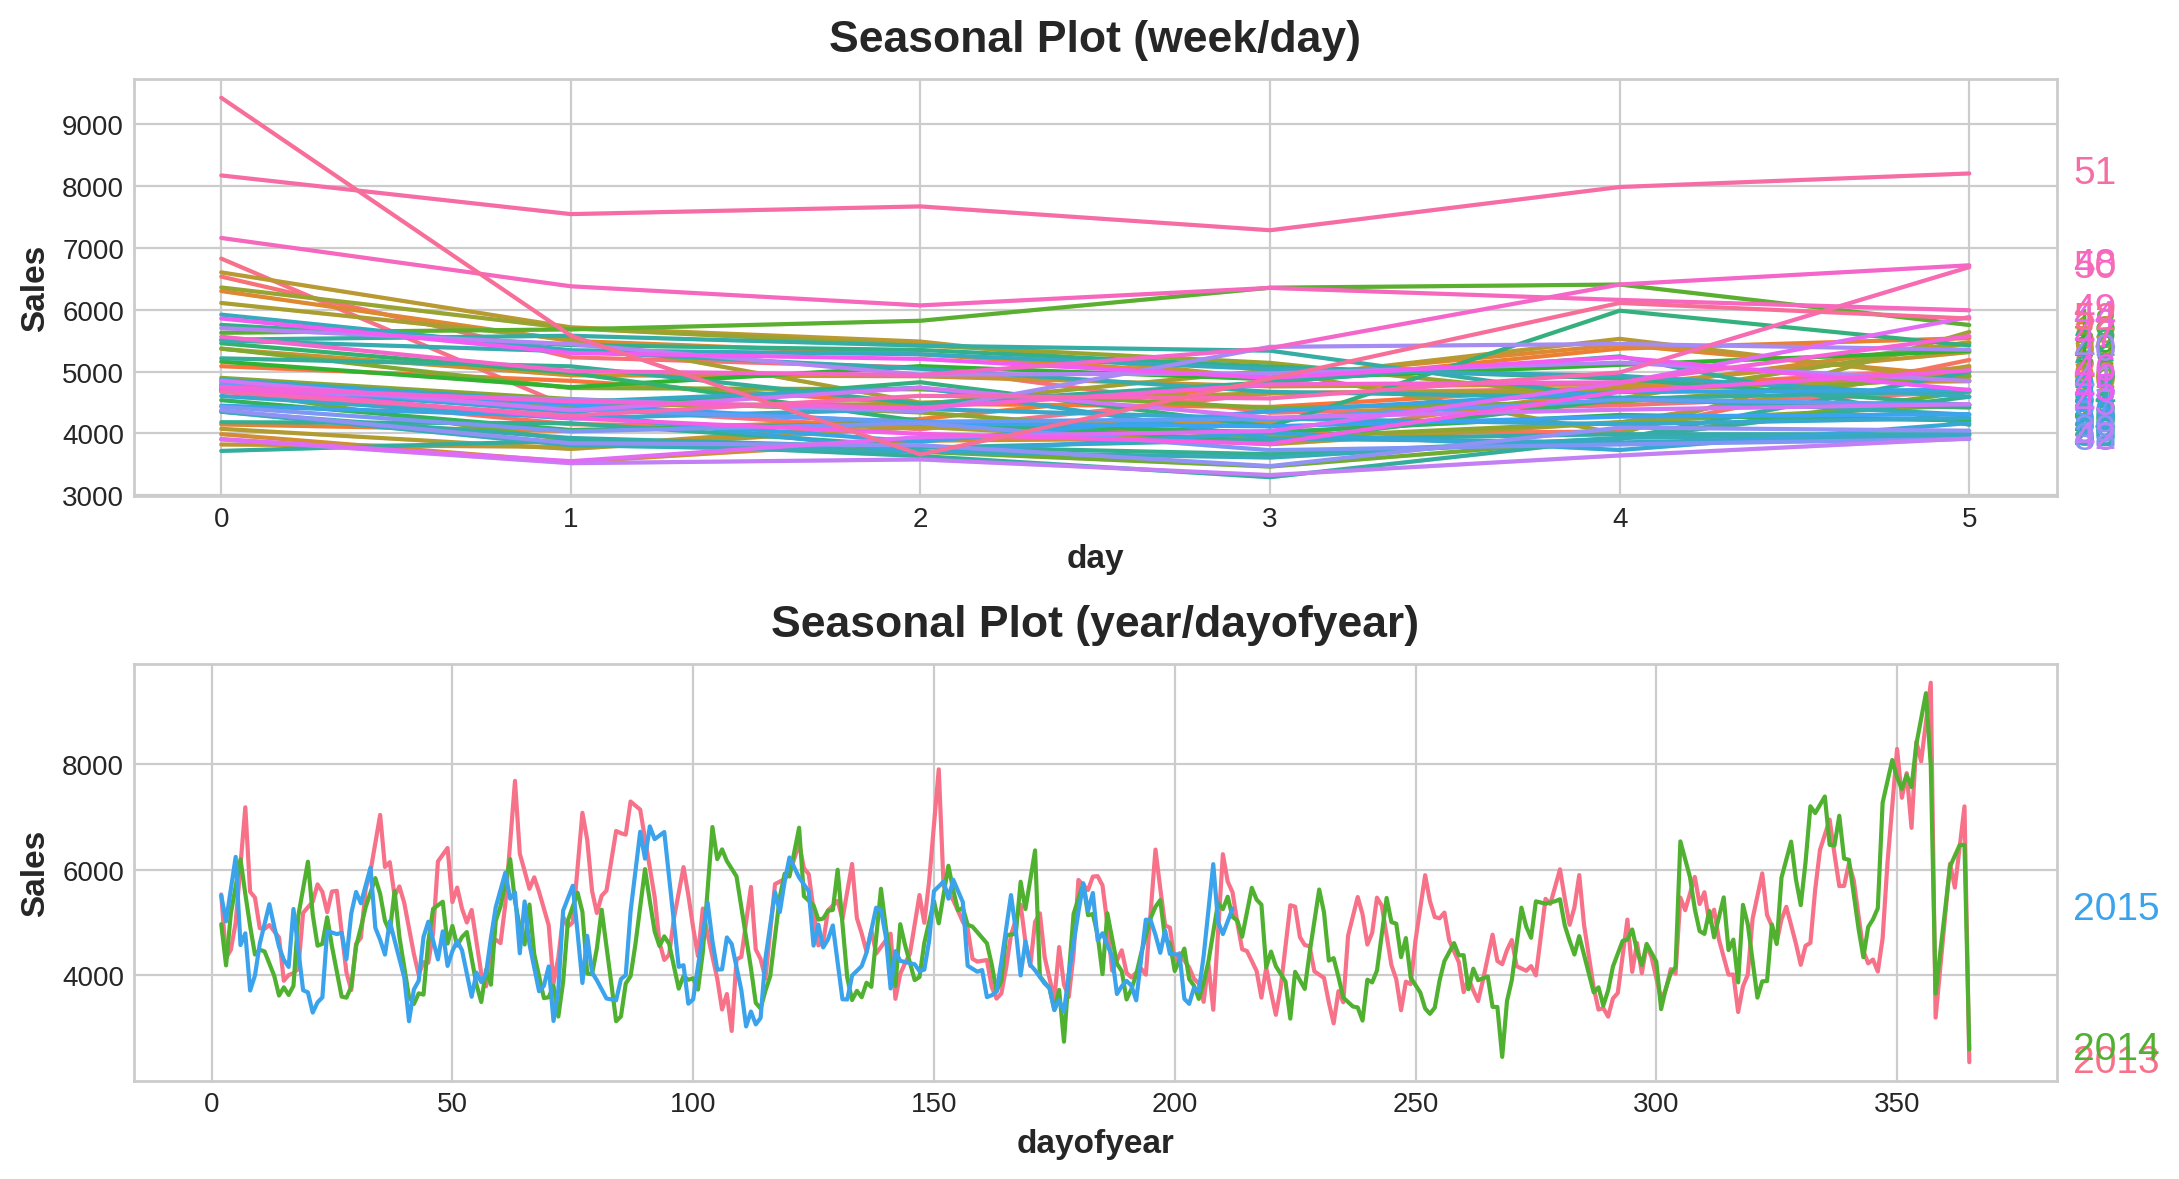

In [334]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
# seasonal_plot(X, y="Sales", period="week", freq="day", ax=ax0)
(seasonal_plot(X, y="Sales", period="week", freq="day", ax = ax0))
seasonal_plot(X, y="Sales", period="year", freq="dayofyear", ax=ax1);

In [335]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

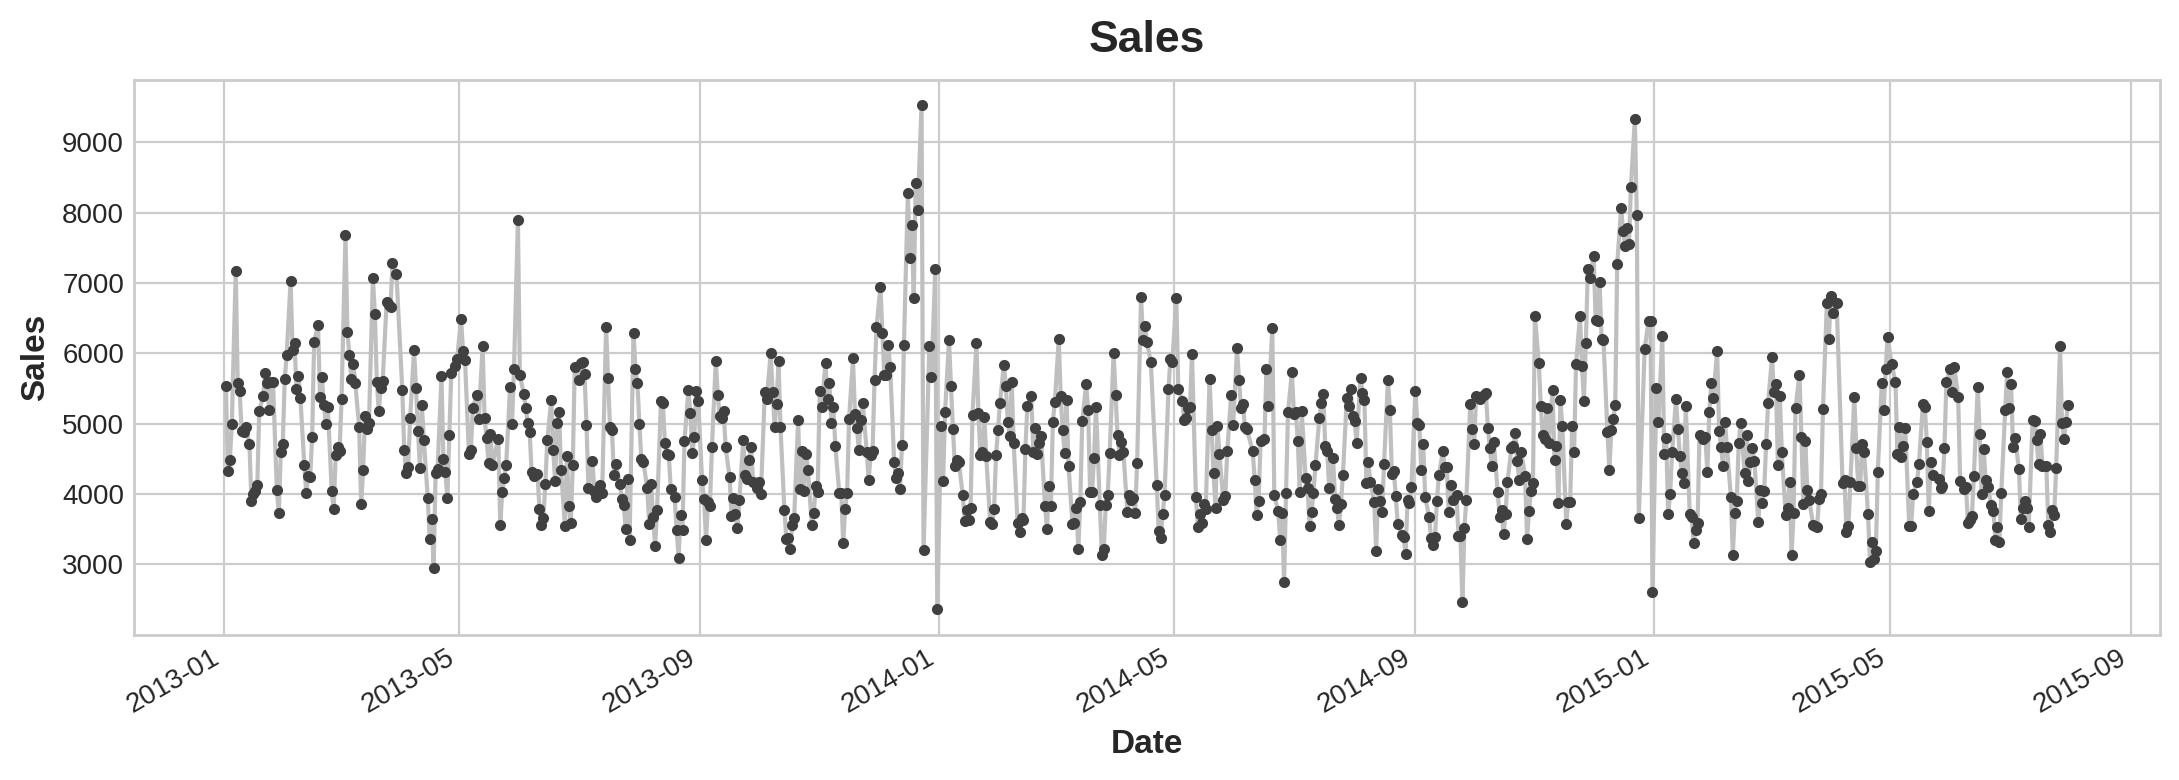

In [336]:

ax = df.Sales.plot(title='Sales', **plot_params)
_ = ax.set(ylabel="Sales")

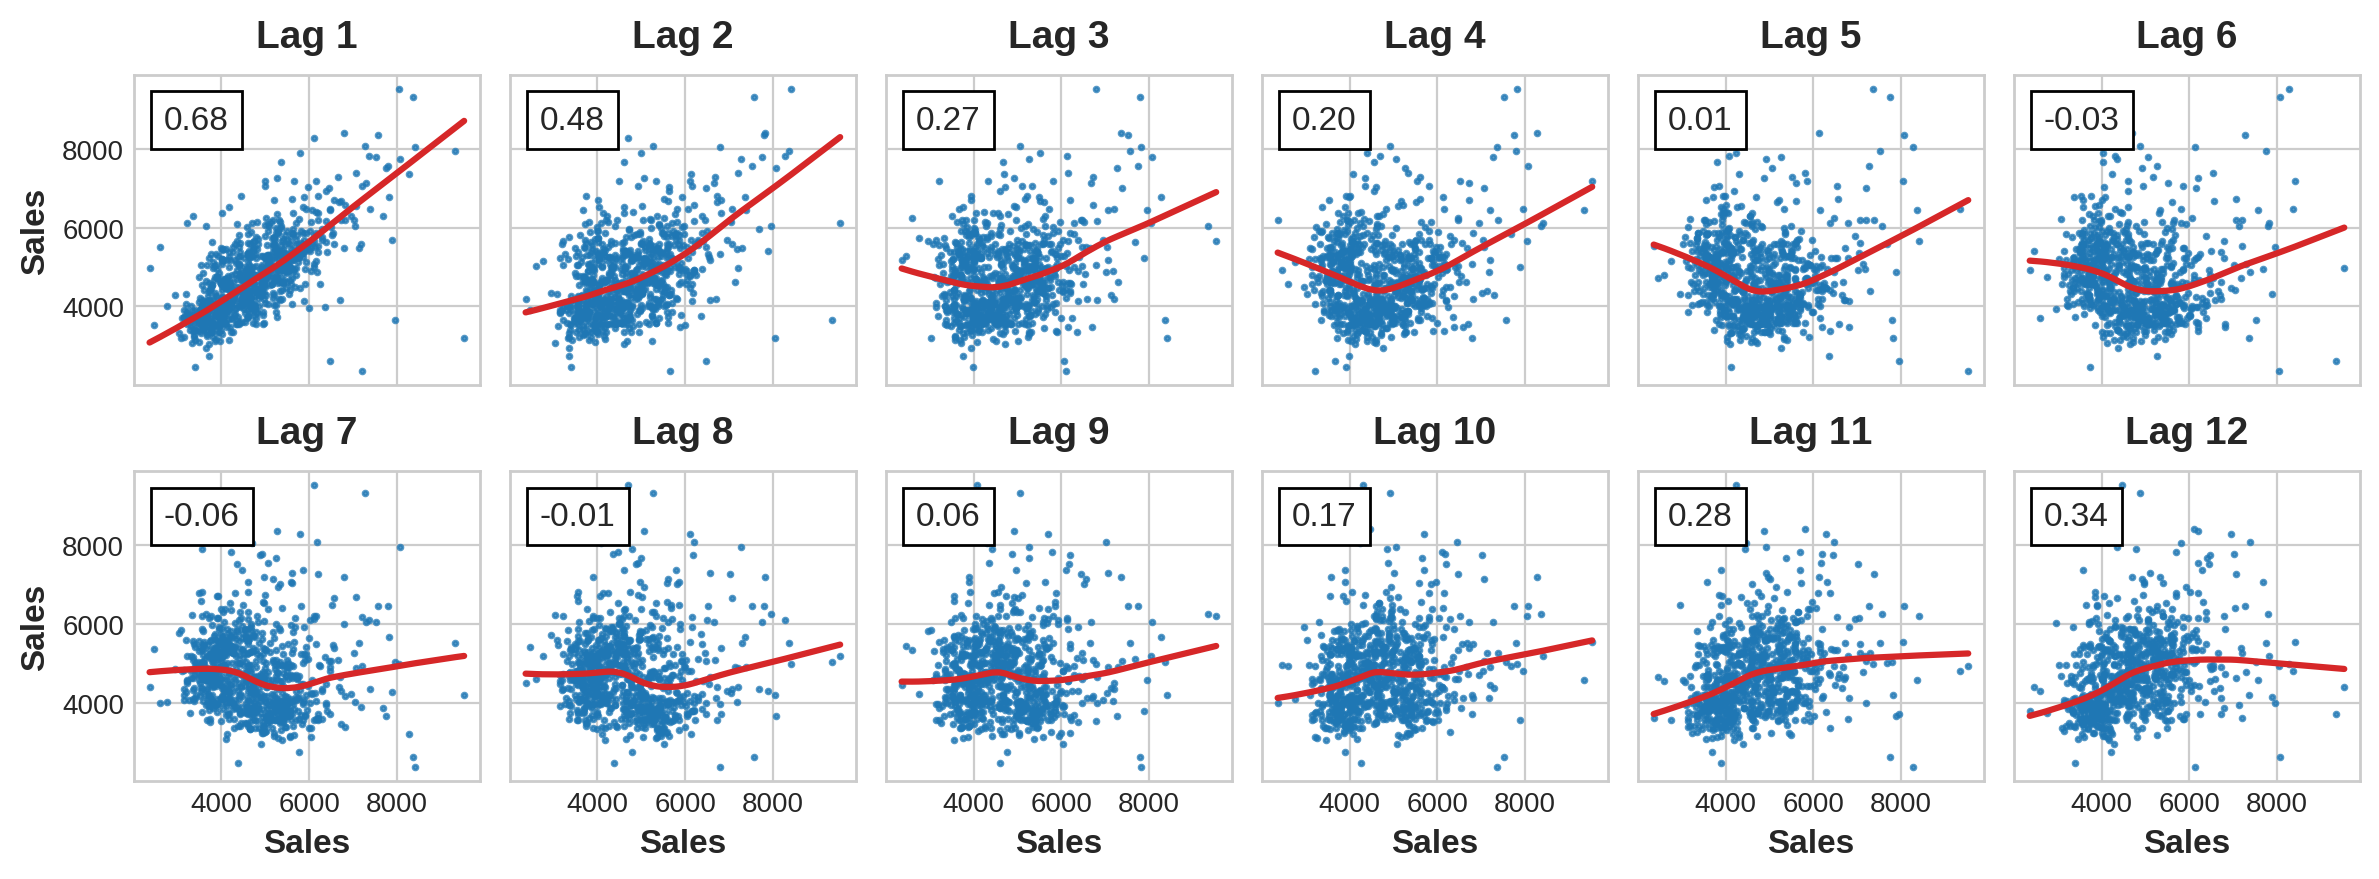

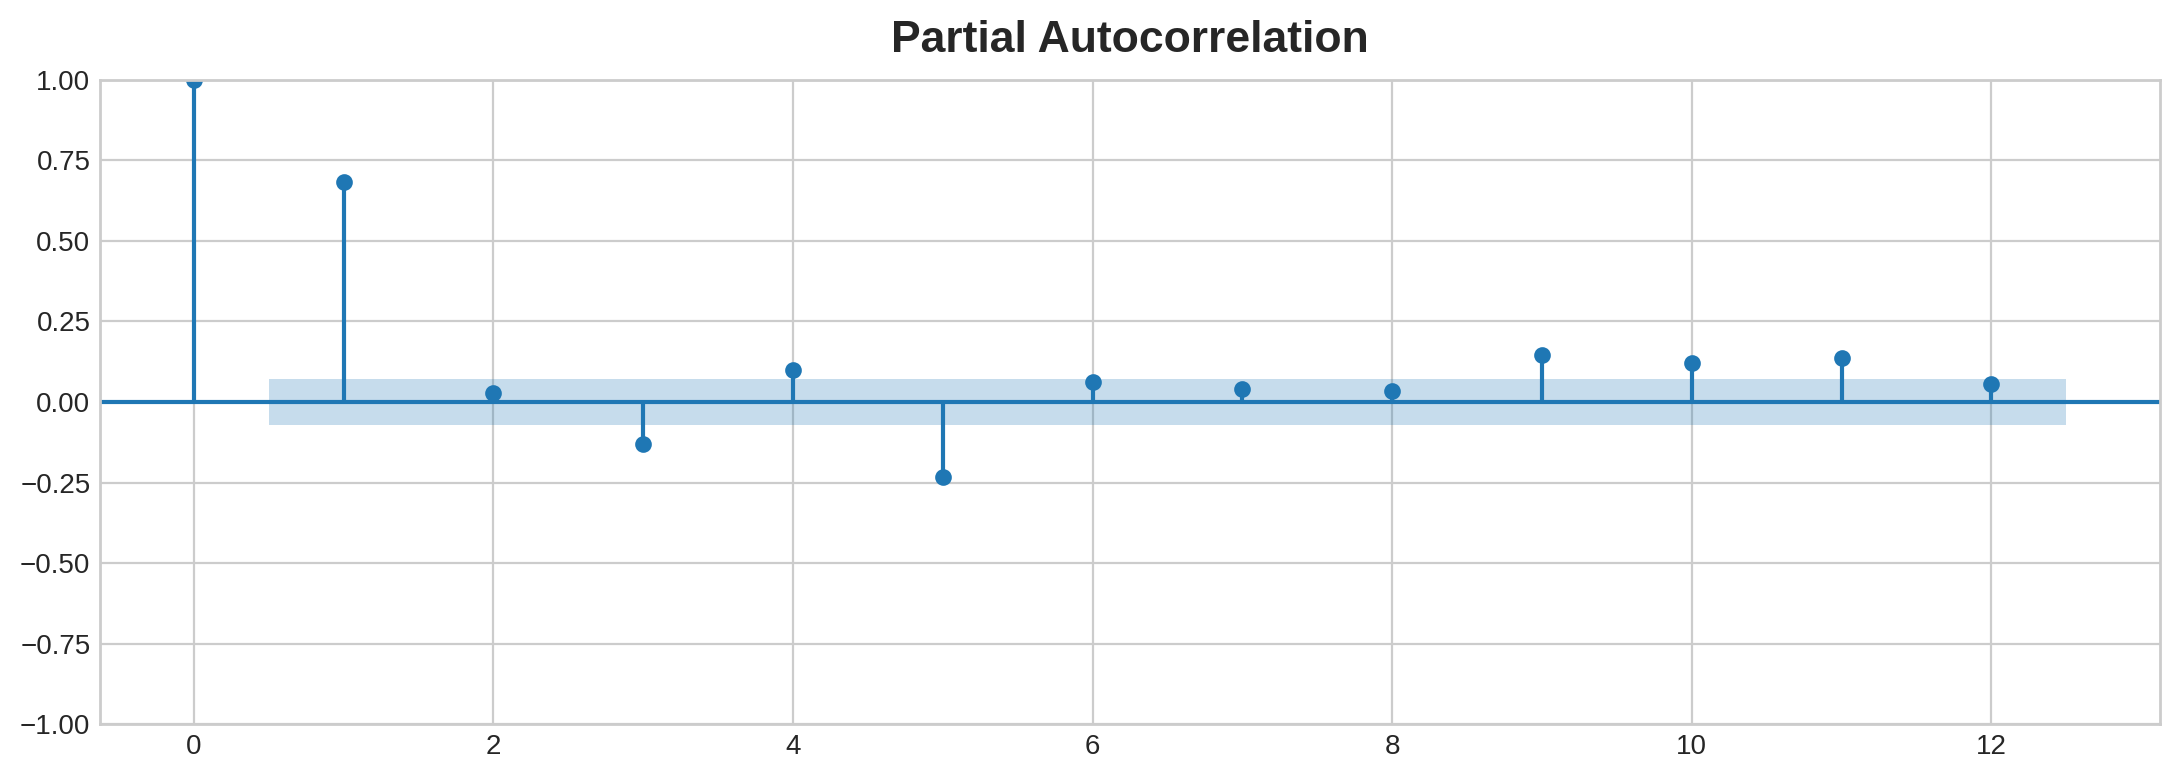

In [337]:
hi = plot_lags(df.Sales, lags=12, nrows=2)
print()
_ = plot_pacf(df.Sales, lags=12)

In [338]:
df

,Sales,Customers,Open,Promo,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,...,year,month,day,StateHoliday_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,5530,668,1,0,1270.0,9.0,2008.0,0,NaN,NaN,...,2013,1,2,True,False,False,True,False,False,False
2013-01-03,4327,578,1,0,1270.0,9.0,2008.0,0,NaN,NaN,...,2013,1,3,True,False,False,False,True,False,False
2013-01-04,4486,619,1,0,1270.0,9.0,2008.0,0,NaN,NaN,...,2013,1,4,True,False,False,False,False,True,False
2013-01-05,4997,635,1,0,1270.0,9.0,2008.0,0,NaN,NaN,...,2013,1,5,True,False,False,False,False,False,True
2013-01-07,7176,785,1,1,1270.0,9.0,2008.0,0,NaN,NaN,...,2013,1,7,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,6102,612,1,1,1270.0,9.0,2008.0,0,NaN,NaN,...,2015,7,27,True,True,False,False,False,False,False
2015-07-28,5011,560,1,1,1270.0,9.0,2008.0,0,NaN,NaN,...,2015,7,28,True,False,True,False,False,False,False
2015-07-29,4782,523,1,1,1270.0,9.0,2008.0,0,NaN,NaN,...,2015,7,29,True,False,False,True,False,False,False


In [339]:
def make_specific_lags(df, column, lags):
    lagged_data = pd.concat(
        {
            f'{column}_lag_{i}': df[column].shift(i)
            for i in lags
        },
        axis=1
    )
    return pd.concat([df, lagged_data], axis=1)



X = make_specific_lags(df,'Sales',  [1,3,5])
X  = X.fillna(0.0)

In [340]:
train_data

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,...,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,1,3,5530,668,1,0,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
2013-01-03,1,4,4327,578,1,0,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
2013-01-04,1,5,4486,619,1,0,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
2013-01-05,1,6,4997,635,1,0,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
2013-01-07,1,1,7176,785,1,1,0,1,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-17,1,6,5255,622,1,0,0,0,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
2015-01-19,1,1,3721,480,1,0,0,0,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False
2015-01-20,1,2,3680,462,1,0,0,0,1270.0,9.0,...,False,False,True,False,True,False,False,False,False,False


In [341]:
X

,Sales,Customers,Open,Promo,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,...,StateHoliday_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,Sales_lag_1,Sales_lag_3,Sales_lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,5530,668,1,0,1270.0,9.0,2008.0,0,0.0,0.0,...,True,False,False,True,False,False,False,0.0,0.0,0.0
2013-01-03,4327,578,1,0,1270.0,9.0,2008.0,0,0.0,0.0,...,True,False,False,False,True,False,False,5530.0,0.0,0.0
2013-01-04,4486,619,1,0,1270.0,9.0,2008.0,0,0.0,0.0,...,True,False,False,False,False,True,False,4327.0,0.0,0.0
2013-01-05,4997,635,1,0,1270.0,9.0,2008.0,0,0.0,0.0,...,True,False,False,False,False,False,True,4486.0,5530.0,0.0
2013-01-07,7176,785,1,1,1270.0,9.0,2008.0,0,0.0,0.0,...,True,True,False,False,False,False,False,4997.0,4327.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,6102,612,1,1,1270.0,9.0,2008.0,0,0.0,0.0,...,True,True,False,False,False,False,False,4364.0,3769.0,3558.0
2015-07-28,5011,560,1,1,1270.0,9.0,2008.0,0,0.0,0.0,...,True,False,True,False,False,False,False,6102.0,3706.0,3464.0
2015-07-29,4782,523,1,1,1270.0,9.0,2008.0,0,0.0,0.0,...,True,False,False,True,False,False,False,5011.0,4364.0,3769.0


In [342]:
df

,Sales,Customers,Open,Promo,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,...,year,month,day,StateHoliday_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,5530,668,1,0,1270.0,9.0,2008.0,0,NaN,NaN,...,2013,1,2,True,False,False,True,False,False,False
2013-01-03,4327,578,1,0,1270.0,9.0,2008.0,0,NaN,NaN,...,2013,1,3,True,False,False,False,True,False,False
2013-01-04,4486,619,1,0,1270.0,9.0,2008.0,0,NaN,NaN,...,2013,1,4,True,False,False,False,False,True,False
2013-01-05,4997,635,1,0,1270.0,9.0,2008.0,0,NaN,NaN,...,2013,1,5,True,False,False,False,False,False,True
2013-01-07,7176,785,1,1,1270.0,9.0,2008.0,0,NaN,NaN,...,2013,1,7,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,6102,612,1,1,1270.0,9.0,2008.0,0,NaN,NaN,...,2015,7,27,True,True,False,False,False,False,False
2015-07-28,5011,560,1,1,1270.0,9.0,2008.0,0,NaN,NaN,...,2015,7,28,True,False,True,False,False,False,False
2015-07-29,4782,523,1,1,1270.0,9.0,2008.0,0,NaN,NaN,...,2015,7,29,True,False,False,True,False,False,False


In [343]:
# Create target series and data splits
y = df.Sales.copy()
X = X.drop(columns=["Sales"])
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [344]:
X_train

,Customers,Open,Promo,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,StoreType_a,...,StateHoliday_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,Sales_lag_1,Sales_lag_3,Sales_lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,668,1,0,1270.0,9.0,2008.0,0,0.0,0.0,False,...,True,False,False,True,False,False,False,0.0,0.0,0.0
2013-01-03,578,1,0,1270.0,9.0,2008.0,0,0.0,0.0,False,...,True,False,False,False,True,False,False,5530.0,0.0,0.0
2013-01-04,619,1,0,1270.0,9.0,2008.0,0,0.0,0.0,False,...,True,False,False,False,False,True,False,4327.0,0.0,0.0
2013-01-05,635,1,0,1270.0,9.0,2008.0,0,0.0,0.0,False,...,True,False,False,False,False,False,True,4486.0,5530.0,0.0
2013-01-07,785,1,1,1270.0,9.0,2008.0,0,0.0,0.0,False,...,True,True,False,False,False,False,False,4997.0,4327.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-11-29,749,1,0,1270.0,9.0,2008.0,0,0.0,0.0,False,...,True,False,False,False,False,False,True,7195.0,5328.0,6527.0
2014-12-01,723,1,1,1270.0,9.0,2008.0,0,0.0,0.0,False,...,True,True,False,False,False,False,False,7066.0,6144.0,5815.0
2014-12-02,717,1,1,1270.0,9.0,2008.0,0,0.0,0.0,False,...,True,False,True,False,False,False,False,7380.0,7195.0,5328.0


In [345]:
# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

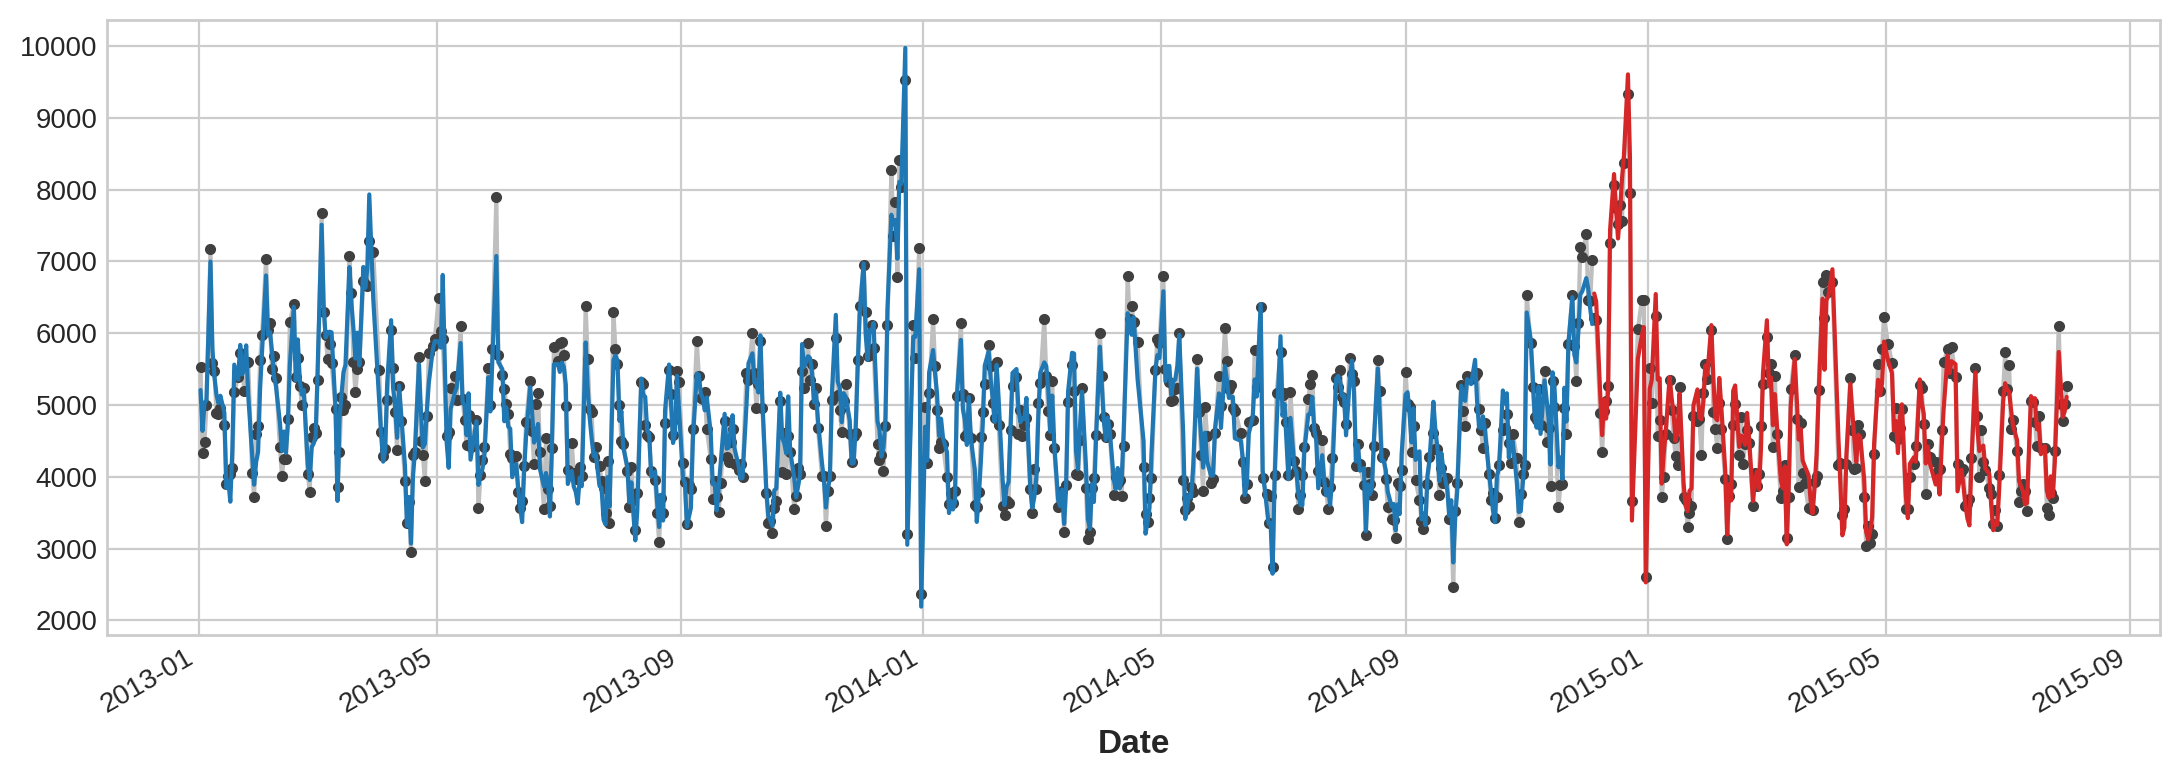

In [346]:
x = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

In [347]:
import plotly.graph_objects as go

# Create traces for actual and predicted values
trace_actual = go.Scatter(x=y_test.index, y=y_test.values, mode='lines+markers', name='Actual Values', line=dict(color='blue'))
trace_predicted = go.Scatter(x=y_fore.index, y=y_fore.values, mode='lines+markers', name='Predicted Values', line=dict(color='red', dash='dash'))

# Create figure layout
layout = go.Layout(title='Comparison of Predicted and Actual Values',
                   xaxis=dict(title='Sample Index'),
                   yaxis=dict(title='Value'),
                   legend=dict(x=0.1, y=1.1, orientation='h'),
                   hovermode='closest',
                   template='plotly_white')

# Create figure object
fig = go.Figure(data=[trace_actual, trace_predicted], layout=layout)

# Display the figure
fig.show()


In [348]:
intercept = model.intercept_
coefficients = model.coef_

# Description of the trained model
print("Trained Linear Regression Model:")
print(f"Intercept (Beta0): {intercept:.2f}")
print("Coefficients (Weights):")
for i, coef in enumerate(coefficients):
    print(f"Feature {i+1}: {coef:.2f}")

# Equation of the fitted model
equation_parts = [f"{coef:.2f} * X{i+1}" for i, coef in enumerate(coefficients)]
equation = f"Price = {intercept:.2f} + " + " + ".join(equation_parts)
print(f"Equation: {equation}")

Trained Linear Regression Model:
Intercept (Beta0): -233488.99
Coefficients (Weights):
Feature 1: 9.21
Feature 2: 0.00
Feature 3: 472.43
Feature 4: 0.00
Feature 5: 0.00
Feature 6: -0.00
Feature 7: 0.00
Feature 8: 0.00
Feature 9: 0.00
Feature 10: -0.00
Feature 11: 0.00
Feature 12: 0.00
Feature 13: 0.00
Feature 14: 0.00
Feature 15: 0.00
Feature 16: 0.00
Feature 17: 0.00
Feature 18: 0.00
Feature 19: 0.00
Feature 20: 115.52
Feature 21: 22.27
Feature 22: 1.31
Feature 23: 0.00
Feature 24: 71.28
Feature 25: -8.23
Feature 26: -30.65
Feature 27: -90.76
Feature 28: -18.56
Feature 29: 76.91
Feature 30: 0.06
Feature 31: -0.04
Feature 32: -0.01
Equation: Price = -233488.99 + 9.21 * X1 + 0.00 * X2 + 472.43 * X3 + 0.00 * X4 + 0.00 * X5 + -0.00 * X6 + 0.00 * X7 + 0.00 * X8 + 0.00 * X9 + -0.00 * X10 + 0.00 * X11 + 0.00 * X12 + 0.00 * X13 + 0.00 * X14 + 0.00 * X15 + 0.00 * X16 + 0.00 * X17 + 0.00 * X18 + 0.00 * X19 + 115.52 * X20 + 22.27 * X21 + 1.31 * X22 + 0.00 * X23 + 71.28 * X24 + -8.23 * X25 + -30.

In [349]:
# prompt: calc rmpse error

import numpy as np
from sklearn.metrics import mean_squared_error

def rmse(actual, predicted):
  return np.sqrt(mean_squared_error(actual, predicted))


rmse_error = rmse(y_train, y_pred)

print("Root Mean Squared Error (RMSE):", rmse_error)


Root Mean Squared Error (RMSE): 252.7699152885155


In [350]:
def calculate_rmspe(actual, predicted):
    # Filter out zero actual values
    non_zero_indices = actual != 0
    actual_non_zero = actual[non_zero_indices]
    predicted_non_zero = predicted[non_zero_indices]

    # Calculate percentage error for each non-zero observation
    percentage_error = (actual_non_zero - predicted_non_zero) / actual_non_zero
    percentage_error_squared = percentage_error ** 2

    # Calculate mean squared percentage error
    mean_squared_percentage_error = np.mean(percentage_error_squared)

    # Calculate RMSPE
    rmspe = np.sqrt(mean_squared_percentage_error)
    return rmspe


# Calculate RMSPE
rmspe_value = calculate_rmspe(y_test, y_fore)
print(f"RMSPE: {rmspe_value:.2f}")


RMSPE: 0.06


In [351]:
# defining lags and plotting lags

In [352]:
df["lags_7"] = df.Sales.rolling(7).mean()

In [353]:
df["lags_7"]

Date
2013-01-02            NaN
2013-01-03            NaN
2013-01-04            NaN
2013-01-05            NaN
2013-01-07            NaN
                 ...     
2015-07-27    4194.000000
2015-07-28    4282.000000
2015-07-29    4456.857143
2015-07-30    4679.142857
2015-07-31    4892.571429
Name: lags_7, Length: 781, dtype: float64

In [354]:
df["std_7"] = df.Sales.rolling(7).std()

In [355]:
df["std_7"]

Date
2013-01-02           NaN
2013-01-03           NaN
2013-01-04           NaN
2013-01-05           NaN
2013-01-07           NaN
                 ...    
2015-07-27    918.869777
2015-07-28    969.433683
2015-07-29    926.517571
2015-07-30    830.270725
2015-07-31    744.956790
Name: std_7, Length: 781, dtype: float64

In [356]:
df

,Sales,Customers,Open,Promo,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,...,day,StateHoliday_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,lags_7,std_7
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,5530,668,1,0,1270.0,9.0,2008.0,0,NaN,NaN,...,2,True,False,False,True,False,False,False,NaN,NaN
2013-01-03,4327,578,1,0,1270.0,9.0,2008.0,0,NaN,NaN,...,3,True,False,False,False,True,False,False,NaN,NaN
2013-01-04,4486,619,1,0,1270.0,9.0,2008.0,0,NaN,NaN,...,4,True,False,False,False,False,True,False,NaN,NaN
2013-01-05,4997,635,1,0,1270.0,9.0,2008.0,0,NaN,NaN,...,5,True,False,False,False,False,False,True,NaN,NaN
2013-01-07,7176,785,1,1,1270.0,9.0,2008.0,0,NaN,NaN,...,7,True,True,False,False,False,False,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,6102,612,1,1,1270.0,9.0,2008.0,0,NaN,NaN,...,27,True,True,False,False,False,False,False,4194.000000,918.869777
2015-07-28,5011,560,1,1,1270.0,9.0,2008.0,0,NaN,NaN,...,28,True,False,True,False,False,False,False,4282.000000,969.433683
2015-07-29,4782,523,1,1,1270.0,9.0,2008.0,0,NaN,NaN,...,29,True,False,False,True,False,False,False,4456.857143,926.517571


In [357]:
residual = (y_test-y_fore)**2
residual_normal = y_test-y_fore
residual_normal_train = y_train-y_pred
residual_train = (y_train-y_pred)**2

In [358]:
residual_rolling_week_train = residual_normal_train.rolling(30).std()
residual_rolling_week_train = residual_rolling_week_train/100

In [359]:
residual_rolling_week_train

Date
2013-01-02         NaN
2013-01-03         NaN
2013-01-04         NaN
2013-01-05         NaN
2013-01-07         NaN
                ...   
2014-11-29    2.766456
2014-12-01    2.937127
2014-12-02    2.938099
2014-12-03    2.907914
2014-12-04    3.343363
Length: 585, dtype: float64

In [360]:
multiplier = 4

In [361]:
variance = sum(residual_train)/(len(residual_train)-1)
standard_deviation = variance**(0.5)

In [362]:
std = standard_deviation

In [363]:
# upper_threshold_limit_train = y_pred + residual_rolling_week
# lower_threshold_limit_train = y_pred - residual_rolling_week
# upper_threshold_limit_test = y_fore + residual_rolling_week
# lower_threshold_limit_test = y_fore - residual_rolling_week

In [364]:
# upper_threshold_limit_train = y_pred + mean_error
# lower_threshold_limit_train = y_pred - mean_error
# upper_threshold_limit_test = y_fore + mean_error
# lower_threshold_limit_test = y_fore - mean_error

In [365]:
upper_threshold_limit_train = y_pred + multiplier*std
lower_threshold_limit_train = y_pred - multiplier*std
upper_threshold_limit_test = y_fore + multiplier*std
lower_threshold_limit_test = y_fore - multiplier*std

In [366]:
std

252.9862353240742

In [367]:
for i in range(4000):
    multiplier = i/1000
    upper_threshold_limit_train = y_pred + multiplier*std*residual_rolling_week_train
    lower_threshold_limit_train = y_pred - multiplier*std*residual_rolling_week_train
    upper_threshold_limit_test = y_fore + multiplier*std*residual_rolling_week_train
    lower_threshold_limit_test = y_fore - multiplier*std*residual_rolling_week_train
    if y_train.between(lower_threshold_limit_train, upper_threshold_limit_train).all():
        break
multiplier
# mean_error = abs(residual_normal)/len(residual_normal)
# for i in range(4000):
#     multiplier = i/1000
# #     upper_threshold_limit_train = y_pred + mean_error*multiplier
# #     lower_threshold_limit_train = y_pred - mean_error*multiplier
#     upper_threshold_limit_test = y_fore + mean_error*multiplier
#     lower_threshold_limit_test = y_fore - mean_error*multiplier
#     if y_train.between(lower_threshold_limit_train, upper_threshold_limit_train).all():
#         break
# multiplier

3.999

In [368]:
sam = upper_threshold_limit_train.isna().sum()
print(sam)

29


In [369]:
residual_rolling_week_train

Date
2013-01-02         NaN
2013-01-03         NaN
2013-01-04         NaN
2013-01-05         NaN
2013-01-07         NaN
                ...   
2014-11-29    2.766456
2014-12-01    2.937127
2014-12-02    2.938099
2014-12-03    2.907914
2014-12-04    3.343363
Length: 585, dtype: float64

In [370]:
multiplier = 1.6
upper_threshold_limit_train = y_pred + multiplier*std
lower_threshold_limit_train = y_pred - multiplier*std
upper_threshold_limit_test = y_fore + multiplier*std
lower_threshold_limit_test = y_fore - multiplier*std

import plotly.graph_objects as go

# Create traces for actual and predicted values
trace_actual = go.Scatter(x=y_train.index, y=y_train.values, mode='lines+markers', name='Actual Values', line=dict(color='blue'))
trace_predicted = go.Scatter(x=y_pred.index, y=y_pred.values, mode='lines+markers', name='Predicted Values', line=dict(color='red', dash='dash'))
UTL_test = go.Scatter(x = upper_threshold_limit_train.index, y = upper_threshold_limit_train.values, mode = 'lines+markers', name = 'Upper Threshold Limit', line=dict(color='lightgreen'))
LTL_test = go.Scatter(x = lower_threshold_limit_train.index, y = lower_threshold_limit_train.values, mode = 'lines+markers', name = 'Lower Threshold Limit', line=dict(color="yellow"))

fill_between = go.Scatter(
    x=pd.concat([upper_threshold_limit_train.index.to_series(), lower_threshold_limit_train.index.to_series()[::-1]]),
    y=pd.concat([upper_threshold_limit_train, lower_threshold_limit_train[::-1]]),
    fill='toself',
    fillcolor='rgba(0, 100, 80, 0.1)',  # Light shade
    line=dict(color='rgba(255,255,255,0)'),  # No line
    showlegend=False,
    hoverinfo='skip'
)

# Create figure layout
# layout = go.Layout(title='Comparison of Predicted and Actual Values',
#                    xaxis=dict(title='Sample Index'),
#                    yaxis=dict(title='Value'),
#                    legend=dict(x=0.1, y=1.1, orientation='h'),
#                    hovermode='closest',
#                    template='plotly_white')

# Create figure object
fig = go.Figure(data=[trace_actual, trace_predicted,fill_between], layout=layout)

# Display the figure
fig.show()

In [371]:
multiplier = 1.2
upper_threshold_limit_train = y_pred + multiplier*std*residual_rolling_week_train
lower_threshold_limit_train = y_pred - multiplier*std*residual_rolling_week_train
upper_threshold_limit_test = y_fore + multiplier*std*residual_rolling_week_train
lower_threshold_limit_test = y_fore - multiplier*std*residual_rolling_week_train

In [372]:
import plotly.graph_objects as go

# Create traces for actual and predicted values
trace_actual = go.Scatter(x=y_train.index, y=y_train.values, mode='lines+markers', name='Actual Values', line=dict(color='blue'))
trace_predicted = go.Scatter(x=y_pred.index, y=y_pred.values, mode='lines+markers', name='Predicted Values', line=dict(color='red', dash='dash'))
UTL_test = go.Scatter(x = upper_threshold_limit_train.index, y = upper_threshold_limit_train.values, mode = 'lines+markers', name = 'Upper Threshold Limit', line=dict(color='lightgreen'))
LTL_test = go.Scatter(x = lower_threshold_limit_train.index, y = lower_threshold_limit_train.values, mode = 'lines+markers', name = 'Lower Threshold Limit', line=dict(color="yellow"))

fill_between = go.Scatter(
    x=pd.concat([upper_threshold_limit_train.index.to_series(), lower_threshold_limit_train.index.to_series()[::-1]]),
    y=pd.concat([upper_threshold_limit_train, lower_threshold_limit_train[::-1]]),
    fill='toself',
    fillcolor='rgba(0, 100, 80, 0.1)',  # Light shade
    line=dict(color='rgba(255,255,255,0)'),  # No line
    showlegend=False,
    hoverinfo='skip'
)

# Create figure layout
# layout = go.Layout(title='Comparison of Predicted and Actual Values',
#                    xaxis=dict(title='Sample Index'),
#                    yaxis=dict(title='Value'),
#                    legend=dict(x=0.1, y=1.1, orientation='h'),
#                    hovermode='closest',
#                    template='plotly_white')

# Create figure object
fig = go.Figure(data=[trace_actual, trace_predicted,fill_between], layout=layout)

# Display the figure
fig.show()

In [373]:
# upper_threshold_limit_train = y_pred + mean_error
# lower_threshold_limit_train = y_pred - mean_error
# upper_threshold_limit_test = y_fore + mean_error
# lower_threshold_limit_test = y_fore - mean_error


import plotly.graph_objects as go

# Create traces for actual and predicted values
trace_actual = go.Scatter(x=y_test.index, y=y_test.values, mode='lines+markers', name='Actual Values', line=dict(color='blue'))
trace_predicted = go.Scatter(x=y_fore.index, y=y_fore.values, mode='lines+markers', name='Predicted Values', line=dict(color='red', dash='dash'))
UTL_test = go.Scatter(x = upper_threshold_limit_test.index, y = upper_threshold_limit_test.values, mode = 'lines+markers', name = 'Upper Threshold Limit', line=dict(color='lightgreen'))
LTL_test = go.Scatter(x = lower_threshold_limit_test.index, y = lower_threshold_limit_test.values, mode = 'lines+markers', name = 'Lower Threshold Limit', line=dict(color="yellow"))

fill_between = go.Scatter(
    x=pd.concat([upper_threshold_limit_test.index.to_series(), lower_threshold_limit_test.index.to_series()[::-1]]),
    y=pd.concat([upper_threshold_limit_test, lower_threshold_limit_test[::-1]]),
    fill='toself',
    fillcolor='rgba(0, 100, 80, 0.1)',  # Light shade
    line=dict(color='rgba(255,255,255,0)'),  # No line
    showlegend=False,
    hoverinfo='skip'
)

# Create figure layout
# layout = go.Layout(title='Comparison of Predicted and Actual Values',
#                    xaxis=dict(title='Sample Index'),
#                    yaxis=dict(title='Value'),
#                    legend=dict(x=0.1, y=1.1, orientation='h'),
#                    hovermode='closest',
#                    template='plotly_white')

# Create figure object
fig = go.Figure(data=[trace_actual, trace_predicted,fill_between], layout=layout)

# Display the figure
fig.show()

In [374]:
fill_between

Scatter({
    'fill': 'toself',
    'fillcolor': 'rgba(0, 100, 80, 0.1)',
    'hoverinfo': 'skip',
    'line': {'color': 'rgba(255,255,255,0)'},
    'showlegend': False,
    'x': array([datetime.datetime(2013, 1, 2, 0, 0),
                datetime.datetime(2013, 1, 3, 0, 0),
                datetime.datetime(2013, 1, 4, 0, 0), ...,
                datetime.datetime(2013, 1, 4, 0, 0),
                datetime.datetime(2013, 1, 3, 0, 0),
                datetime.datetime(2013, 1, 2, 0, 0)], dtype=object),
    'y': array([nan, nan, nan, ..., nan, nan, nan])
})

In [375]:
x=pd.concat([upper_threshold_limit_test.index.to_series(), lower_threshold_limit_test.index.to_series()[::-1]])

In [376]:
x

Date
2013-01-02   2013-01-02
2013-01-03   2013-01-03
2013-01-04   2013-01-04
2013-01-05   2013-01-05
2013-01-07   2013-01-07
                ...    
2013-01-07   2013-01-07
2013-01-05   2013-01-05
2013-01-04   2013-01-04
2013-01-03   2013-01-03
2013-01-02   2013-01-02
Name: Date, Length: 1562, dtype: datetime64[ns]

In [377]:
model_threshold = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [378]:
df_residual_train = pd.DataFrame(residual_normal_train)
# df_residual.index
df_residual_train = df_residual_train.asfreq('D')
df_residual_train.index
# df_residual_train = df_residual_train*residual_rolling_week_train
residual_rolling_week_train

Date
2013-01-02         NaN
2013-01-03         NaN
2013-01-04         NaN
2013-01-05         NaN
2013-01-07         NaN
                ...   
2014-11-29    2.766456
2014-12-01    2.937127
2014-12-02    2.938099
2014-12-03    2.907914
2014-12-04    3.343363
Length: 585, dtype: float64

In [379]:
# df_residual[0] = df_residual[0]

In [380]:
import plotly.express as px
# re = px.data.tips()
fig = px.histogram(df_residual_train, x = [0])
fig.show()

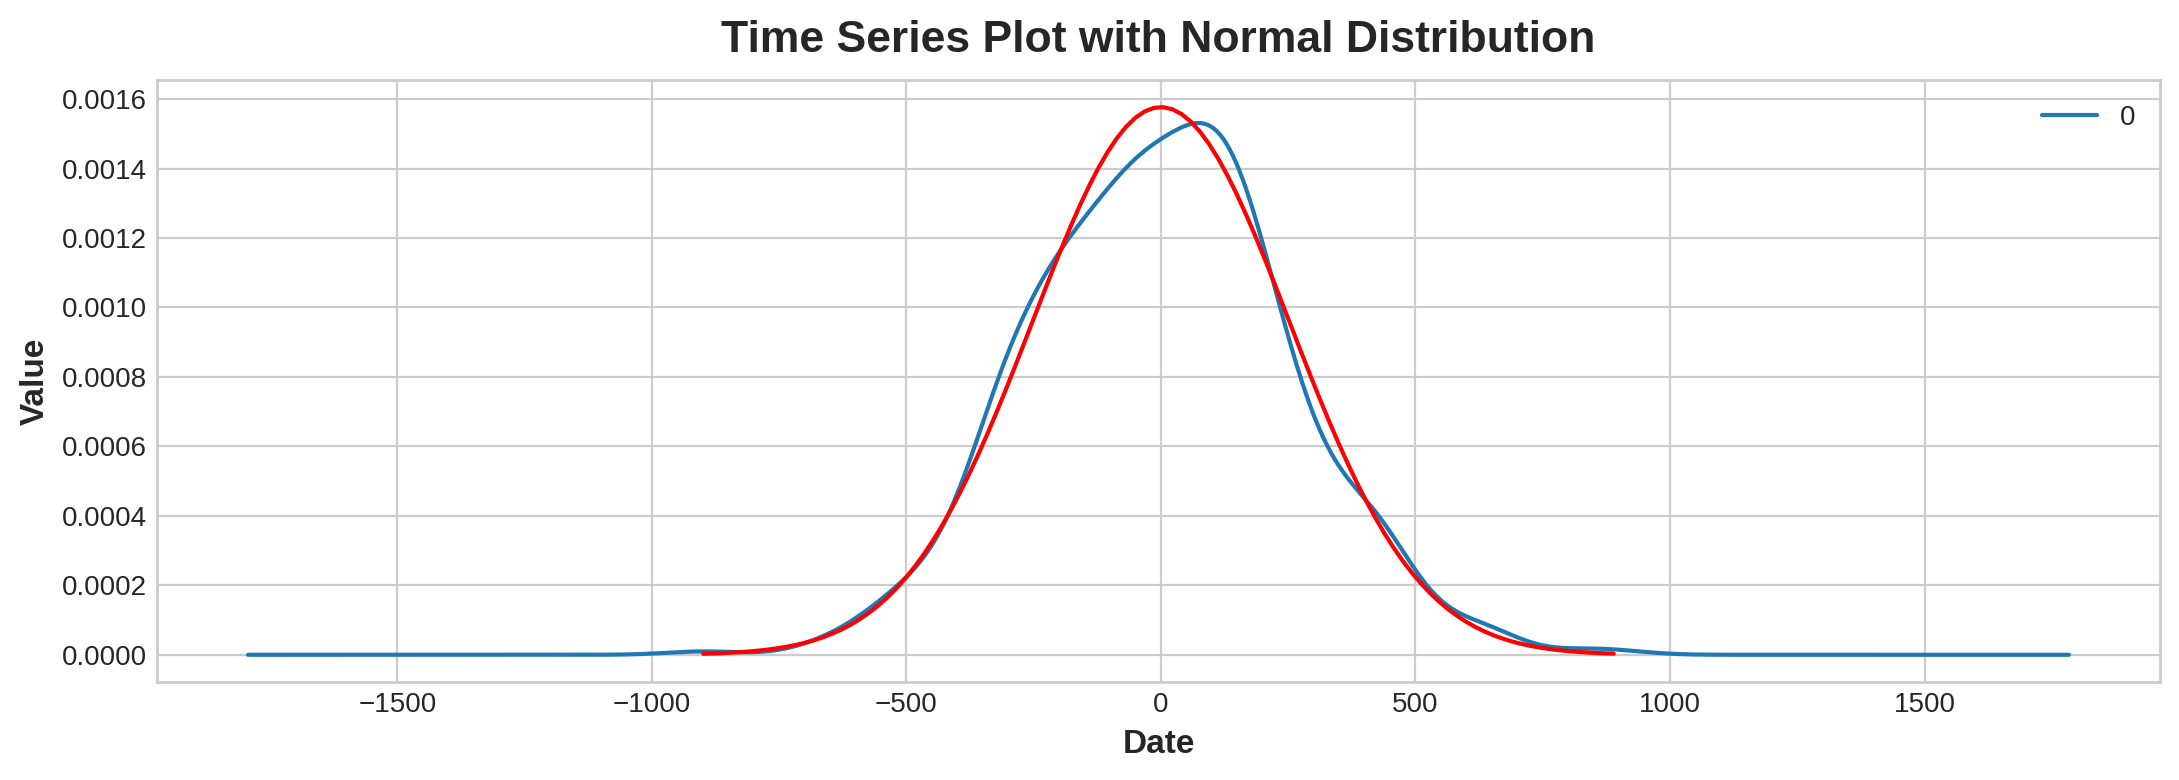

In [381]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
df_residual = df_residual_train
s = df_residual
normalization_factor = (df_residual - sum(df_residual)/len(residual))/std
# Assuming 's' is your pandas series
s.plot(kind='density')

# Calculate the mean and standard deviation of your data
mu = s.mean()
sigma = s.std()

# Create a range of x values from the min to the max of your data
x = np.linspace(s.min(), s.max(), 100)

# Generate the normal distribution for the range of x values
plt.plot(x, stats.norm.pdf(x, mu, sigma), color='red')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot with Normal Distribution')
plt.show()


In [382]:
upper_threshold_limit_train = y_pred + multiplier*std
lower_threshold_limit_train = y_pred - multiplier*std
upper_threshold_limit_test = y_fore + multiplier*std
lower_threshold_limit_test = y_fore - multiplier*std

import plotly.graph_objects as go

# Create traces for actual and predicted values
trace_actual = go.Scatter(x=y_test.index, y=y_test.values, mode='lines+markers', name='Actual Values', line=dict(color='blue'))
trace_predicted = go.Scatter(x=y_fore.index, y=y_fore.values, mode='lines+markers', name='Predicted Values', line=dict(color='red', dash='dash'))
UTL_test = go.Scatter(x = upper_threshold_limit_test.index, y = upper_threshold_limit_test.values, mode = 'lines+markers', name = 'Upper Threshold Limit', line=dict(color='lightgreen'))
LTL_test = go.Scatter(x = lower_threshold_limit_test.index, y = lower_threshold_limit_test.values, mode = 'lines+markers', name = 'Lower Threshold Limit', line=dict(color="yellow"))

fill_between = go.Scatter(
    x=pd.concat([upper_threshold_limit_test.index.to_series(), lower_threshold_limit_test.index.to_series()[::-1]]),
    y=pd.concat([upper_threshold_limit_test, lower_threshold_limit_test[::-1]]),
    fill='toself',
    fillcolor='rgba(0, 100, 80, 0.1)',  # Light shade
    line=dict(color='rgba(255,255,255,0)'),  # No line
    showlegend=False,
    hoverinfo='skip'
)

# Create figure layout
# layout = go.Layout(title='Comparison of Predicted and Actual Values',
#                    xaxis=dict(title='Sample Index'),
#                    yaxis=dict(title='Value'),
#                    legend=dict(x=0.1, y=1.1, orientation='h'),
#                    hovermode='closest',
#                    template='plotly_white')

# Create figure object
fig = go.Figure(data=[trace_actual, trace_predicted,fill_between], layout=layout)

# Display the figure
fig.show()


In [383]:
# import matplotlib.pyplot as plt

# residual.plot()
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.title('Standard Deviations')
# plt.show()


In [384]:
std

252.9862353240742

In [385]:
multipliers = []
for i in range(200):
    multipliers.append(1+i/100)
# multipliers

In [386]:
thresholds = {}
for i in multipliers:
    upper_threshold = y_fore + i * std
    lower_threshold = y_fore - i * std
    thresholds[i] = (upper_threshold, lower_threshold)

In [387]:
# thresholds

In [388]:
errors = {}
for confidence, (upper, lower) in thresholds.items():
    outliers = np.sum((y_test > upper) | (y_test < lower))
    total_points = len(y_test)
    error_rate = outliers / total_points
    errors[confidence] = error_rate

In [389]:
# errors

In [390]:
1 - min(errors.values())

0.9948979591836735

In [391]:
key = errors.get(min(errors.values()), None)
key

In [392]:
key

In [393]:
print(key)

None


In [394]:
df

,Sales,Customers,Open,Promo,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,...,day,StateHoliday_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,lags_7,std_7
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,5530,668,1,0,1270.0,9.0,2008.0,0,NaN,NaN,...,2,True,False,False,True,False,False,False,NaN,NaN
2013-01-03,4327,578,1,0,1270.0,9.0,2008.0,0,NaN,NaN,...,3,True,False,False,False,True,False,False,NaN,NaN
2013-01-04,4486,619,1,0,1270.0,9.0,2008.0,0,NaN,NaN,...,4,True,False,False,False,False,True,False,NaN,NaN
2013-01-05,4997,635,1,0,1270.0,9.0,2008.0,0,NaN,NaN,...,5,True,False,False,False,False,False,True,NaN,NaN
2013-01-07,7176,785,1,1,1270.0,9.0,2008.0,0,NaN,NaN,...,7,True,True,False,False,False,False,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,6102,612,1,1,1270.0,9.0,2008.0,0,NaN,NaN,...,27,True,True,False,False,False,False,False,4194.000000,918.869777
2015-07-28,5011,560,1,1,1270.0,9.0,2008.0,0,NaN,NaN,...,28,True,False,True,False,False,False,False,4282.000000,969.433683
2015-07-29,4782,523,1,1,1270.0,9.0,2008.0,0,NaN,NaN,...,29,True,False,False,True,False,False,False,4456.857143,926.517571


In [395]:
from datetime import datetime
def get_sales(s):
    # s is the date string in the test data
    row = df.loc[(s)]
#     print(s)
    return row

In [396]:
row = get_sales("2015-07-31")
row = row.fillna(0)
row

Sales                                    5263
Customers                                 555
Open                                        1
Promo                                       1
CompetitionDistance                    1270.0
CompetitionOpenSinceMonth                 9.0
CompetitionOpenSinceYear               2008.0
Promo2                                      0
Promo2SinceWeek                             0
Promo2SinceYear                             0
StoreType_a                             False
StoreType_b                             False
StoreType_c                              True
StoreType_d                             False
Assortment_a                             True
Assortment_b                            False
Assortment_c                            False
PromoInterval_Feb,May,Aug,Nov           False
PromoInterval_Jan,Apr,Jul,Oct           False
PromoInterval_Mar,Jun,Sept,Dec          False
year                                     2015
month                             

In [397]:
X_new = pd.DataFrame(data = row)
X_new = X_new.transpose()
X_new

,Sales,Customers,Open,Promo,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,...,day,StateHoliday_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,lags_7,std_7
2015-07-31,5263,555,1,1,1270.0,9.0,2008.0,0,0,0,...,31,True,False,False,False,False,True,False,4892.571429,744.95679


In [398]:
X_new = make_specific_lags(X_new, "Sales",  [1,3,5])

In [399]:
X_new  = X_new.fillna(0.0)
X_new = X_new.drop(["Sales", "lags_7", "std_7"], axis = 1)
y_pred_new = pd.Series(model.predict(X_new), index=[row.name])
print(y_pred_new)

2015-07-31    5054.491047
dtype: float64


In [400]:
UTL = upper_threshold_limit_test[row.name].item()
LTL = lower_threshold_limit_test[row.name].item()
print(UTL, "utl")

5416.442016000905 utl


In [404]:
if y_pred_new.item()>UTL:
  print(f"High Demand Alert at {row.name} at store number {store_number_er}")

In [402]:
if y_pred_new.item()<LTL:
  print(f"Low Demand Alert at {row.name} at store number {store_number_er}")